[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/demos/cnn/cnn_foundations.ipynb) 


# Convolutional Neural Networks

Convolutional Neural Networks (CNN) are typically introduced as a model for image data. However,  to understand what kernels/filters, convolutions and convolutional layers do, let us stay in a context that is more familiar to us - time series!

Here is the outline of today:

    1. Introductory example: Time series reloaded
    2. Convoluting kernels as matrix multiplication
    3. Convolutional layers for image processing
    4. Convolutional layers in Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

## 1. Introductory example: Time series reloaded

Image a random walk that moves from the position in $t-1$ to a new value in $t$ based on a random Gaussian error. You are likely to know this pattern from the hypothesis, that the stock market is best understood as a random walk. 

In [2]:
x = np.zeros(100)
for i in range(0,100):
    if i==0:
        x[i] = np.random.normal(loc=0, scale=1)
    else:
        x[i] = x[i-1] + np.random.normal(loc=0, scale=1)

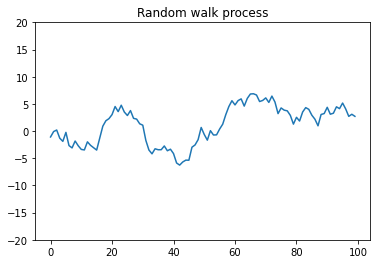

In [3]:
plt.plot(x)
plt.ylim(-20,20)
plt.title('Random walk process')
plt.show()

### Smoothing: The moving average

To understand what convolutions do, it is often useful to start from a moving average. Moving averages are often used to smooth a time series. We can use the above curve as an example. It fluctuates a lot. Let's smooth it using a moving average for better for visualization as a simple forecast. 

You are probably familiar with a moving average: it is the average over the previous $k$ periods:

$$ MA(x_i, \ldots, x_{i-k}) = \frac{1}{K} \sum\limits^{K-1}_{k=0} x_{i-k} $$

The window size K determines how much smoothing we want. 

In [4]:
WINDOW_SIZE = 5

In [5]:
x_ma = x.copy()

To smooth the curve, we replace the value in each period by the average over the period and the previous K-1 periods. If our data were stored as *Pandas Series*, the Pandas function `Rolling` offers a neat way to compute moving averages over (time) series. However, it is easy enough to implement it ourselves.

In [6]:
for i in range(WINDOW_SIZE-1,100):
    x_ma[i] = np.mean(x[(i-WINDOW_SIZE+1):(i+1)])

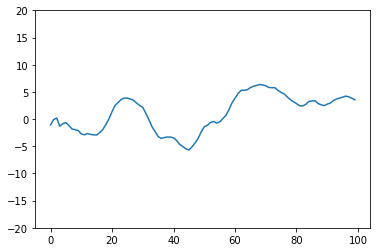

In [7]:
plt.plot(x_ma)
plt.ylim(-20,20)
plt.show()

That looks much less erratic! Smoothing can be useful to filter out noise and make the overall trend more visible.

### The moving average as a kernel

It turns out that we can understand the moving average as a much more general concept called a kernel. Because we are doing deep learning, we call kernels *filters*. A kernel or filter is just a matrix (of weights). 

We can write the *moving average* function above as a matrix like this:

In [8]:
[1/WINDOW_SIZE]*WINDOW_SIZE

[0.2, 0.2, 0.2, 0.2, 0.2]

In [9]:
kernel = np.array([1/WINDOW_SIZE]*WINDOW_SIZE)

In [10]:
kernel.dot(x[0:WINDOW_SIZE])

-0.8362050831634413

In [11]:
x_ma[WINDOW_SIZE-1]

-0.8362050831634413

![Moving average as a matrix multiplication](moving_average_kernel.png)

A convolution is then the sum over the element-wise multiplication.

To be fair, the convolution just calculates the average over five values. When we multiply the averaging kernel with pieces of our time series, i.e. move it over the data, we again see the moving average.

![Moving average as a matrix multiplication](moving_average_loop.png)

In [12]:
x_ma2 = x.copy()

In [13]:
for i in range(WINDOW_SIZE-1, 100):
    x_ma2[i] = kernel.dot(x[(i-WINDOW_SIZE+1):(i+1)])

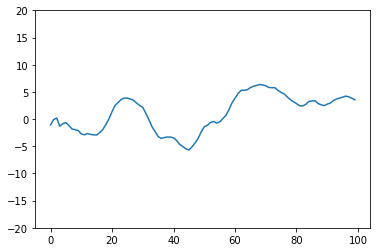

In [14]:
plt.plot(x_ma2)
plt.ylim(-20,20)
plt.show()

Recent observations are typically more relevant. How would you change this into a weighted moving average, where observations are weighted less the farer they are in the past?

Spoiler alert: Convolutional networks learn the weights of these filters from training on the data.

## 2. Convoluting kernels as matrix multiplication

In [15]:
kernel = np.array([1/WINDOW_SIZE]*WINDOW_SIZE)

Looping the filter over the data is not what happens in the convolutional network. In fact, it is much more efficient to convert the actual calculation into a matrix multiplication. We have done matrix multiplications before and we know that our infrastructure is optimized to do them.

To be able to do matrix multiplication instead of using a loop, we transform the data until the problem looks like a matrix multiplication problem!

![Moving average as a matrix multiplication](moving_average_CNN.png)

In [16]:
def data2vectors(data, kernel_size):
    X = []
    
    for i in range(0, len(data)-kernel_size+1):
        x = data[i:(i+kernel_size)]    
        X.append(x)
           
    return np.array(X)

In [17]:
# Test the function
test = np.arange(10)
print(test)
data2vectors(test, 3)

[0 1 2 3 4 5 6 7 8 9]


array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])

Note how the function looks similar to our data construction function for the LSTM exercises! That's not a coincidence. There as well, we broke up the data to make it fit into the structure we had in mind.

Let's also solve a little problem that is becoming more inconvenient: In the image above, you can see that our generic approach doesn't know how to deal with the first 4 values. Since we don't have earlier observations, we can't really calculate the average over five values. 

We use a heuristic solution called `padding`. In this case, we'll make the (naive) assumption that the time series hasn't changed before the first value and will copy the first value into the past. In image data, we usually pad with the value 0 (black).

In [18]:
x[:5]

array([-1.0856306 , -0.08828516,  0.19469334, -1.31160137, -1.89020162])

In [19]:
x_padded = np.hstack([np.repeat(x[0], 4), x.copy()])

See how the first fake four values are now equal to the real first value. When can now (technically) calculate a moving average even for the first period!

In [20]:
x_padded

array([-1.0856306 , -1.0856306 , -1.0856306 , -1.0856306 , -1.0856306 ,
       -0.08828516,  0.19469334, -1.31160137, -1.89020162, -0.23876509,
       -2.66544433, -3.09435696, -1.8284207 , -2.6951611 , -3.37404725,
       -3.46875622, -1.9773666 , -2.61626859, -3.06025055, -3.49460183,
       -1.28867175,  0.89811434,  1.90216824,  2.28835464,  3.02572322,
        4.51645524,  3.58062137,  4.75645042,  3.50256975,  2.86481825,
        3.77192345,  2.34324274,  2.20317402,  1.34141913,  1.08579976,
       -1.71278935, -3.48432245, -4.18419969, -3.25673725, -3.43037294,
       -3.42752702, -2.73930431, -3.61884065, -3.33521333, -4.14057985,
       -5.86824934, -6.25914914, -5.68534327, -5.34675422, -5.35858472,
       -2.96621945, -2.55330729, -1.57457128,  0.66357205, -0.63051327,
       -1.66930148,  0.07441075, -0.72365199, -0.69396876,  0.37534721,
        1.2660536 ,  3.02093978,  4.51658392,  5.58597659,  4.81326788,
        5.60813054,  5.92240254,  4.59613708,  6.01343613,  6.82

In [21]:
x_vector = data2vectors(x_padded, kernel_size = WINDOW_SIZE)

In [22]:
x_vector[0:5]

array([[-1.0856306 , -1.0856306 , -1.0856306 , -1.0856306 , -1.0856306 ],
       [-1.0856306 , -1.0856306 , -1.0856306 , -1.0856306 , -0.08828516],
       [-1.0856306 , -1.0856306 , -1.0856306 , -0.08828516,  0.19469334],
       [-1.0856306 , -1.0856306 , -0.08828516,  0.19469334, -1.31160137],
       [-1.0856306 , -0.08828516,  0.19469334, -1.31160137, -1.89020162]])

The last step is to calculate the dot product with the full times series (broken up into pieces of 5 values) and the averaging kernel. 

In [23]:
x_ma3 = x_vector.dot(kernel)

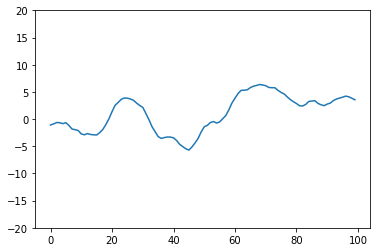

In [24]:
plt.plot(x_ma3)
plt.ylim(-20,20)
plt.show()

The optimization of convolutions for GPUs (graphics processing units AKA graphics cards) or TPUs (tensor processing units) is an ongoing and important computer science task. The above codes demonstrate how the same task, smoothing the time series, can be approached from different angels. The calculations are the same. The results are the same. But the degree to which these computations can be implemented efficiently and in a highly-scalable manner, differs. The last approach is most receptive to HW acceleration. 

### Takeaways from the Moving Average

We now know that a kernel is a matrix of values. When a kernel is convoluted/moved over the data to transform the data in a context window, that same kernel (matrix of values) is multiplied with pieces of the data. Since the kernel is typically much smaller than the full input data, we don't need to train many weights. 

## 3. Convolutional layers for image processing 

Time series data has one dimension (earlier<>later), but image data is a good example of data that has two dimensions (left<>right, up<>down). 

In [25]:
from tensorflow.keras.datasets import mnist 

In [26]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's understand the data, which is now 3D because we have $N$ observations!

In [27]:
train_images.shape

(60000, 28, 28)

Image data (like multivariate time series data) is multidimensional. Each observation here is a square greyscale image with 28 pixels on the horizontal and vertical.  

In [28]:
train_images[0][:10,:25]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0],
      

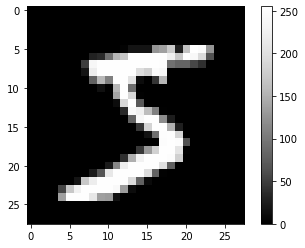

In [29]:
plt.figure()
plt.imshow(train_images[0], cmap="Greys_r", vmin = 0, vmax = 255)
plt.colorbar()
plt.grid(False)
plt.show()

We have labels on the type of product, e.g. `9` ankle boot

In [30]:
train_labels[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

### 2D convolutions

So how do convolutions work in a 2D space and what do they do?

Let's take this example of a specific filter used to detect edges.

In [31]:
kernel = np.array([[1,1],[-1,-1]])

In [32]:
kernel

array([[ 1,  1],
       [-1, -1]])

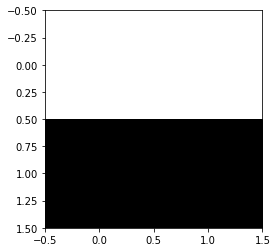

In [33]:
plt.imshow(kernel, cmap="Greys_r", vmin = -1, vmax = 1)
plt.show()

![Edge filter](edge_filter.png)

#### Padding

Like with the time series data, we will have to pad the image a little to apply our filter at the sides of the image. 

In [34]:
img = train_images[0]

In [35]:
img = np.c_[img, np.zeros(28)] 
img = np.c_[     np.zeros(28), img] 

In [36]:
img = np.r_[img, np.zeros(30).reshape(1,-1)]
img = np.r_[     np.zeros(30).reshape(1,-1), img] 

In [37]:
img.shape

(30, 30)

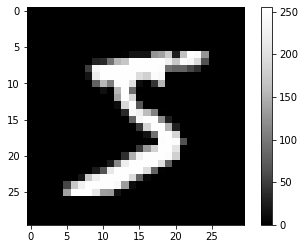

In [38]:
plt.figure()
plt.imshow(img, cmap="Greys_r", vmin = 0, vmax = 255)
plt.colorbar()
plt.grid(False)
plt.show()

Not much has changed, except for extra 0 pixels around the image, which is now 30x30 pixels in size.

#### Edge detector convolution

We apply the filter to pieces of the images, just like with the time series data. Let's just have a quick look what a piece of the image will look like.

In [39]:
i_x, i_y = 15,15

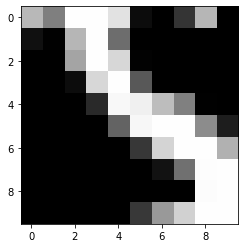

In [40]:
# Zoom into 10x10 piece here
plt.imshow(img[(i_y-5):(i_y+5), (i_x-5):(i_x+5)],
           cmap="Greys_r", vmin = 0, vmax = 255);

Alright. We will loop over all pieces in the image (again in a loop for simplicity). For each piece, we apply the filter by multiplying it element-wise and then summing up the resulting values.

In [41]:
output = np.zeros(train_images[0].shape)

for i_x in range(1,29):
    for i_y in range(1,29):
        output[i_y-1, i_x-1] = np.sum(kernel * img[(i_y-1):(i_y+1), (i_x-1):(i_x+1)])

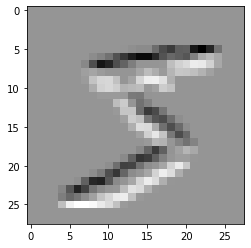

In [42]:
plt.imshow(output,
           cmap="Greys_r")
plt.show()

Wow, the kernel looks at a small piece of the overall image and extracts information on that small space. Think  about that: The 2D convolution from the time series example helped us extract information at a small context of time (5 periods). The kernel here extracts informations at a small space of the image (3x3 pixels). Convolutions are useful whenever some 'space' in the data is a meaningful concept.

This is much different from the use cases we considered in Business Analytics and Data Science. Consider, for example, churn prediction. Since the row order of customer in churn data and/or the column order of variables is arbitrary and can be reordered without losing information, applying convolutions to structured data is usually not useful. On the other hand, tabular data like time series or panel data is a use case, since the row or column order may be used to imply time.

Note: The Hamard product (element-wise multiplication) and sum may seem weird: `np.sum(kernel * img[(i_y-1):(i_y+2), (i_x-1):(i_x+2)])`. But just like with the 2D convolutions above, we can formulate the convolution as a vector multiplication and see that the multiplication-sum process comes naturally.

In [43]:
i_y, i_x = 2,20

In [44]:
img[(i_x-1):(i_x+1), (i_y-1):(i_y+1)]

array([[0., 0.],
       [0., 0.]])

In [45]:
# Vectorize the image
img[(i_x-1):(i_x+1), (i_y-1):(i_y+1)].flatten()

array([0., 0., 0., 0.])

In [46]:
# Vectorize the kernel
kernel.flatten()

array([ 1,  1, -1, -1])

In [47]:
np.dot(kernel.flatten(), img[(i_x-1):(i_x+1), (i_y-1):(i_y+1)].flatten())

0.0

## 4. Convolutional layers in keras

Now to apply our convolutions on a much larger scale! 

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, Flatten, MaxPooling2D

In [49]:
#create model
model = Sequential()
#add model layers
nb_filters = 10
nb_out_layer = 10
filter_size = 3
model.add(Conv2D(nb_filters, kernel_size=filter_size, activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(nb_filters, kernel_size=filter_size, activation="relu"))
model.add(Flatten())
model.add(Dense(nb_out_layer, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 10)        100       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 10)        910       
_________________________________________________________________
flatten (Flatten)            (None, 5760)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                57610     
Total params: 58,620
Trainable params: 58,620
Non-trainable params: 0
_________________________________________________________________


Make sure you understand the dimensionality at each stage of the model:

1. Dimension of the input image (28,28,1) -> What is the 3rd dimension?
2. Dimension of the second convolutional layer -> Why 24x24? Why 10 on the third axis?
3. Why does the second convolutional layer have much more parameters than the first?
4. Why the large number of parameters in the Dense layer?

For convolutional layers, we can calculate the number of parameters as `(input_channels * filter_size + 1)* output_channels`.

In [50]:
(1 * (filter_size**2) + 1) * nb_filters

100

In [51]:
(nb_filters * (filter_size**2) + 1) * nb_filters

910

When moving from a convolutional layer to a dense layer, we flatten the output of the former to comply with the specification of the input to a dense layer. That is the purpose of the *Flatten layer* in the above ConvNet. We can calculate the output dimension of the flatten layer as the product along all axes of the input tensor. In our case:

In [52]:
flatten_layer_output = 24**2*nb_filters
flatten_layer_output

5760

For the dense layer, which is also the output layer of our ConvNet, we obtain the number of parameters in the usual way as `(nb_inputs + 1)*nb_outputs`:

In [53]:
nb_out_layer*(flatten_layer_output+1)

57610

#### Max-Pooling

In [54]:
#create model
model = Sequential()

# Add padding to keep the dimensionality of the 'hidden image' constant
model.add(Conv2D(10, kernel_size=3, activation="relu", input_shape=(28,28,1), padding="same", name="conv1"))

# Add a max-pooling layer to reduce the size of the image over which we convolute
model.add(MaxPooling2D(pool_size=(2,2), padding="same"))

model.add(Conv2D(10, kernel_size=3, activation="relu", padding="same", name="conv2"))

model.add(Flatten())
model.add(Dense(10, activation="softmax"))

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 10)        910       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                19610     
Total params: 20,620
Trainable params: 20,620
Non-trainable params: 0
_________________________________________________________________


#### 1x1 Convolution

In [56]:
#create model
model = Sequential()

# Add padding to keep the dimensionality of the 'hidden image' constant
model.add(Conv2D(10, kernel_size=3, activation="relu", input_shape=(28,28,1), padding="same", name="conv1"))
model.add(MaxPooling2D(pool_size=(2,2), padding="same"))
model.add(Conv2D(10, kernel_size=3, activation="relu", padding="same", name="conv2"))

# Add a 1x1 convolution to reduce the dimensionality of the Dense layer
# by reducing the 'depth' of the hidden image
model.add(Conv2D(1, kernel_size=1, activation="relu", padding="same"))

model.add(Flatten())
model.add(Dense(10, activation="softmax"))

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 10)        910       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 1)         11        
_________________________________________________________________
flatten_2 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1970      
Total params: 2,991
Trainable params: 2,991
Non-trainable params: 0
____________________________________________________

#### Model Training

Finally, let's train the model

In [58]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Reshape the images to comply with tensorflow format (height x width x channel)
train_images, test_images = train_images.reshape(train_images.shape[0],28,28,1), test_images.reshape(test_images.shape[0],28,28,1)

In [60]:
test_images.shape

(10000, 28, 28, 1)

Preprocessing for image data is easier/standardized, because we know the technical minimum and maximum values that pixels can take.

In [61]:
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

In [62]:
from keras.utils import np_utils

In [63]:
# one-hot encode the training and testing labels
train_labels = np_utils.to_categorical(train_labels, 10)
test_labels = np_utils.to_categorical(test_labels, 10)

In [64]:
test_labels.shape

(10000, 10)

In [65]:
test_images.shape

(10000, 28, 28, 1)

In [66]:
print(f'Loss and accuracy:\n {model.evaluate(test_images, test_labels)}')

313/313 [==============================] - 1s 2ms/step - loss: 2.3026 - accuracy: 0.0982
Loss and accuracy:
 [2.3026223182678223, 0.0982000008225441]


In [67]:
story = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), 
                  epochs=1, batch_size=128)

469/469 [==============================] - 18s 37ms/step - loss: 2.3017 - accuracy: 0.1116 - val_loss: 2.3011 - val_accuracy: 0.1135


In [68]:
print(f'Loss and accuracy:\n {model.evaluate(test_images, test_labels)}')

313/313 [==============================] - 1s 2ms/step - loss: 2.3011 - accuracy: 0.1135
Loss and accuracy:
 [2.3011081218719482, 0.11349999904632568]


## Further Reading: Pretrained Image Networks

Check out https://keras.io/applications/  -> Documentation for individual models

NOTE: Doesn't really work with fashion MNIST, since the images are too small (28x28) for state-of-the-art models trained on imagenet (starts at 128x128)